In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.io import arff  # read ARFF dataset
import matplotlib.pyplot as plt # Visualise data
import itertools
plt.rcParams["figure.figsize"] = (18, 10)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-eye-state/EEG Eye State.arff


# Leading the Data

In [2]:
from pprint import pprint
fpaths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fpaths.append(os.path.join(dirname, filename))
pprint(fpaths)

['/kaggle/input/eeg-eye-state/EEG Eye State.arff']


In [3]:
eeg_arff = arff.loadarff(fpaths[0]) # Load arff dataset
eeg_df = pd.DataFrame(eeg_arff[0]) # Create Pandas Dataframe from loaded dataset

# Convert eyeDetection from S1 string to int type
eeg_df['eyeDetection'] = eeg_df['eyeDetection'].astype(int)

eeg_df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


# Data

As seen above, the data consists of a total of 15 columns, 14 of which contain time-series data for electrode signals at 14 different locations and the last column indicating eye state (0 for open, 1 for closed)

# Predictor and Response

1. y - Eye state at each time step
2. X - Data frame whose columns contain time-series voltages of each of the 14 locations of electrodes

In [4]:
# Split predictors and response
response = ['eyeDetection']

y = eeg_df[response]
X = eeg_df.drop(response, axis=1)

# Config

1. time_scale: Duration of EEG recording in seconds. This recording lasted 117 seconds
2. N: Total number of samples
3. high_pass: Define a high pass filter, used in frequency-series analysis later
4. Low_pass: Define a low pass filter, used in frequency-series analysis later
5. wave_buckets: Dictionary of frequency ranges of the standard classification of brain signals. The keys are Delta (D), Theta (T), Alpha (A), Beta (B) and Gamma (G) and their coresponding tuples define their frequency ranges (Hz)

In [5]:
time_scale = 117
N = len(y)
high_pass, low_pass = 0, time_scale
wave_buckets = {"D":(0.5, 4), "T":(4, 8), "A":(8, 12), "B":(12, 30), "G":(30, 100)}

# Outliers

The data set contains some outlier in the voltage recorded. As an example, below is the plot of one of the electrodes over time. The outlier's magnitude is so high that it is not possible most of the waveform.

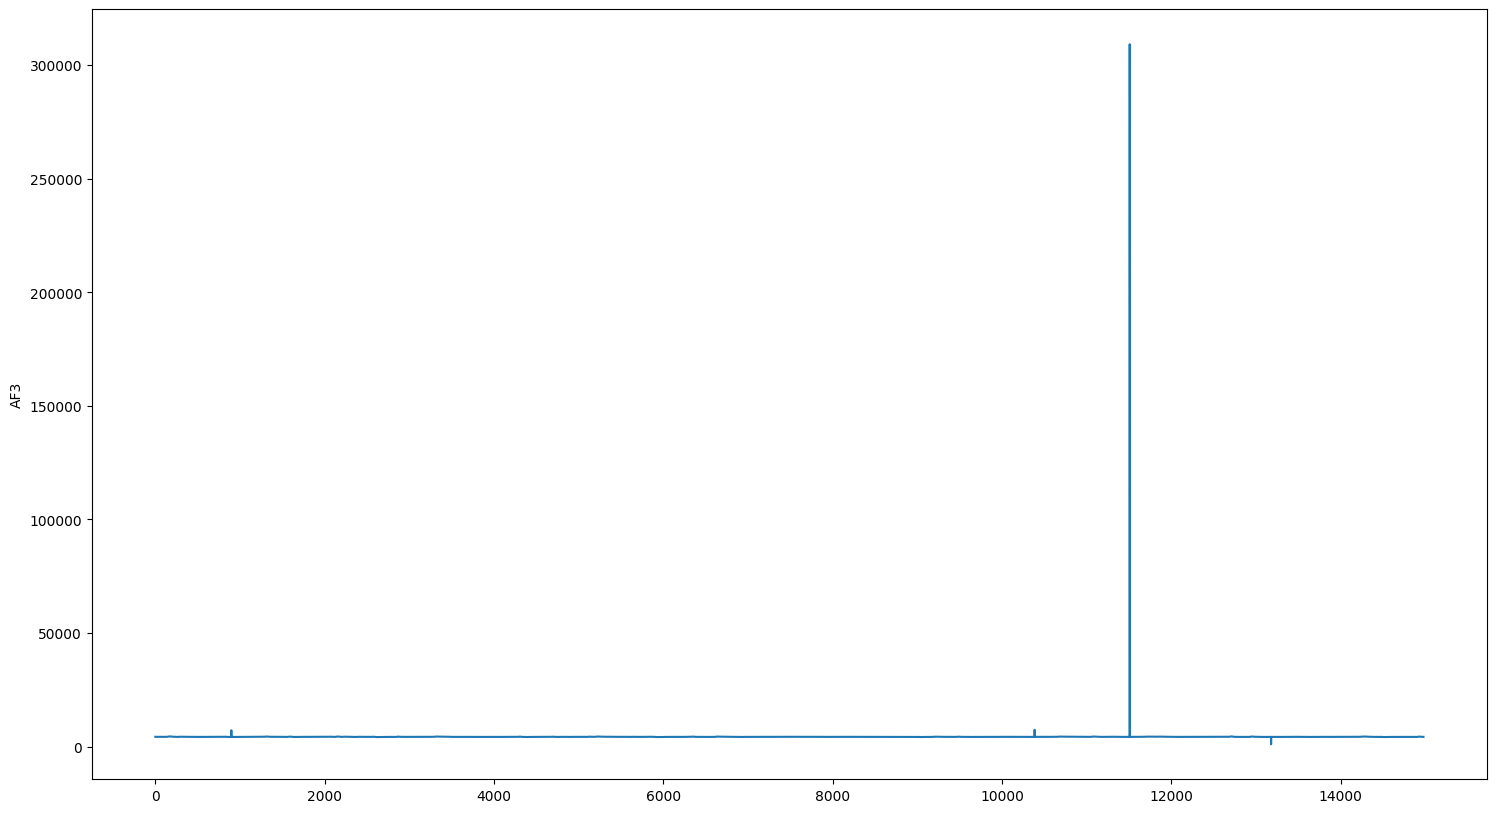

In [6]:
col = "AF3"
plt.ylabel(col)
plt.plot(np.arange(len(X[col])), X[col])

In [7]:
# From a series, returns a range where 99% of the points lie
def outlier_filter(X, y,  span = 0.0002):
    indices = True
    for column in X.columns:
        x_sorted = X[column][np.argsort(X[column])]
        l, h = x_sorted.quantile(span), x_sorted.quantile(1-span)
        indices = indices & (X[column] > l) & (X[column] < h)
    return X.loc[indices], y.loc[indices]

In [8]:
def outliers_removed(X, y, span=0.0002):
    x_sorted = X[np.argsort(X)]
    
    q1, q3 = x_sorted.quantile(span), x_sorted.quantile(1-span)
    indices = (X.iloc[:] > q1) & (X.iloc[:] < q3)
    return X.loc[indices], y.loc[indices]

## Method fo Outlier Adjustment
* Define a percentile value as the boundary between logical data and outliers - stored in span
* Compute the min and max voltage boundary based on the given data and using span - stored in q_low and q_high
* Flag those elements which are inside the defined boundary, and thus are not outliers - stored in not_outliers
* Compute a linear approximation for all rows, by finding the mean of the row above and row below. I used linear extrapolation for the first and last rows
    * I compute an approximation for all rows because the vectorised computation in numpy and pandas makes this operation not very costly, even if only a few of these values will be used
* Replace each row with the computed approximation, where the value is considered an outlier


In [9]:
def adjust_outliers(X, span=0.0002):
    """
    Finds and adjusts the outliers values of a given data frame by linear approximation
    @param X: Dataframe of the 14 electrode time-series data
    @param span: proportion of sorted samples to define a boundary for outliers. 
                Samples which are < 100*span percentile or > 100*(1-span) percentile of the whole sample range are considered outliers
    @return: A dataframe with the same shape as X with outlier voltages adjusted
    """
    
    # Check for outliers and replace then by taking mean of the neighbouring values
    def replace_outliers(x, span=span):
        q_low, q_high = x.quantile(span), x.quantile(1-span)
        not_outliers = (x > q_low) & (x < q_high)
        
        # Of each row in x, coomputes the average of the row above and below it
        # Note: To compute the sum of rows above and below, I have padded the time series data with None values.
        # If the original data had N samples. I have padded it to have N+2 samples, found the element-wise sum and average
        # sliced the series back to N rows. But this results in the first and last element having None values
        pad = pd.Series([None, None])
        adj = ((pd.concat([pad, x]).reset_index() + pd.concat([x, pad]).reset_index()) / 2).iloc[1:-1, 1].values
        
        # For the first and last index, linearly extrapolate the value at the row from the 2 successive and 2 preceding rows 
        # respectively
        adj[0], adj[-1] = 2*x.iloc[1]-x.iloc[2], 2*x.iloc[-2]-x.iloc[-3]
        
        # Replace outliers when needed
        return x.where(not_outliers, adj)
    
    return X.apply(replace_outliers)
     

In [10]:
# Adjusted outlier values in each column
X_adj = adjust_outliers(X)

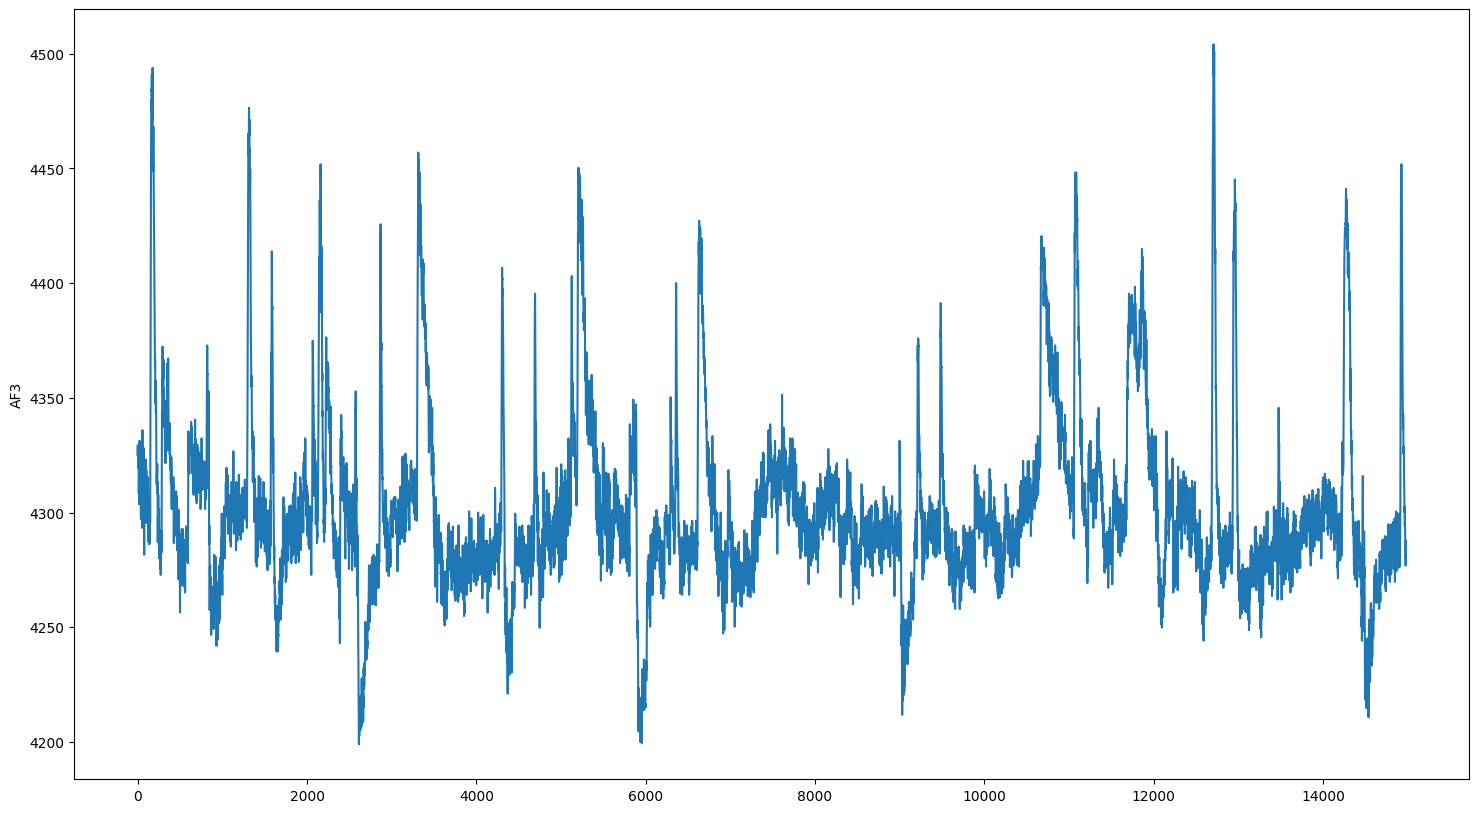

In [11]:
col = "AF3"
plt.ylabel(col)
plt.plot(np.arange(len(X_adj[col])), X_adj[col])

Having adjusted outliers, time to visualise the electrode data with eye state

# Visualise Data
Plotting each electrode's complete time-series recording
1. y-axis: Voltage of the elctrode at the given location
2. x-axis: Time (s)
3. Marking regions where eyes are closed with a red highlight

In [12]:
from itertools import groupby
def get_state_ranges(y):
    
    """
    To condense the eye states recorded over time into ranges of samples where eye was close
    @param y: Time series recording of eye states (0 for eyes open and 1 for eyes closd)
    @return: A list of tuples containing ranges of samples where eyes were closed (y == 1)
    """
    
    if isinstance(y, pd.DataFrame): y = y.values.flatten()
        
    y_ranges = []
    i = 0
    for key, sub in groupby(y):
        group_range = len(list(sub))
        
        # append strt index, and till index
        if key == 1:
            y_ranges.append((i, i + group_range - 1))
        i += group_range
    return y_ranges


In [13]:
# Store the ranges of indices where eyes are closed
y_ranges = get_state_ranges(y)

In [14]:
# Helper functions to scale between sample scale and time scale
def scale(x, n=N, t=time_scale):
    return x * t / n

def inv_scale(x, n=N, t=time_scale):
    return x * n / t

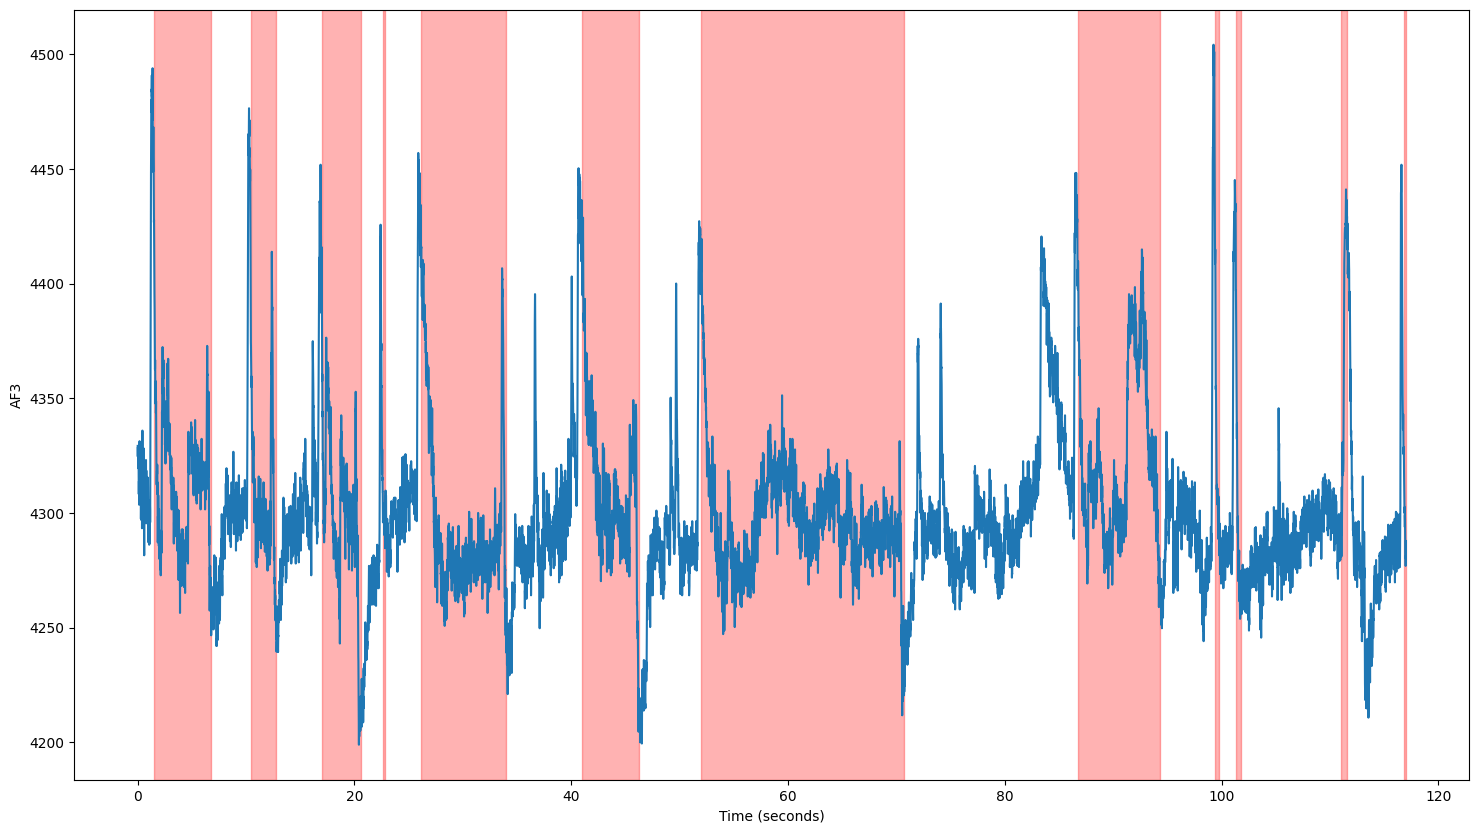

In [15]:
for i, column in enumerate(X_adj.columns):
    if i != 0: break # Used in testing
    
    fig, ax = plt.subplots()
    
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel(column)
    ax.plot(scale(np.arange(len(X_adj[column]))), X_adj[column])
    for i, j in y_ranges:
        ax.axvspan(scale(i), scale(j), color='red', alpha=0.3)
    
    plt.show()
    #fig.savefig(f"{column}: Voltage vs Time_raw data")

Based on the above plots, there seems to be no clear pattern when the eye is closed or open. A better approach may be to analyse the Fourier approximation of these plots

# Fast Fourier Transform (FFT)
* Tools for FFT can be found in Numpy.
* Plotting the Power Spectrum Distribution (PSD) using the computed Fourier approximation, to find any prominant frequencies in the time-series data

In [16]:
# Scaling the high pass and low pass filters from time scale to sample scale for usage in plotting data
sample_high_pass, sample_low_pass = round(inv_scale(high_pass)), round(inv_scale(low_pass))

In [17]:
X_Hat = {col:np.fft.fft(X_adj[col], N) for col in X_adj.columns}
PSD = {col:np.real(x_hat * np.conj(x_hat) / N) for col, x_hat in X_Hat.items()}
frequency_range = scale(np.arange(N).astype(float))

Upon plotting just one of the PSDs (for the electrode located at AF3) we see that there is a significant bias term at frequency = 0 which makes it difficult to clearly valualise the rest of the distribution. This phenomenon is seen in the rest of the electrodes as well.

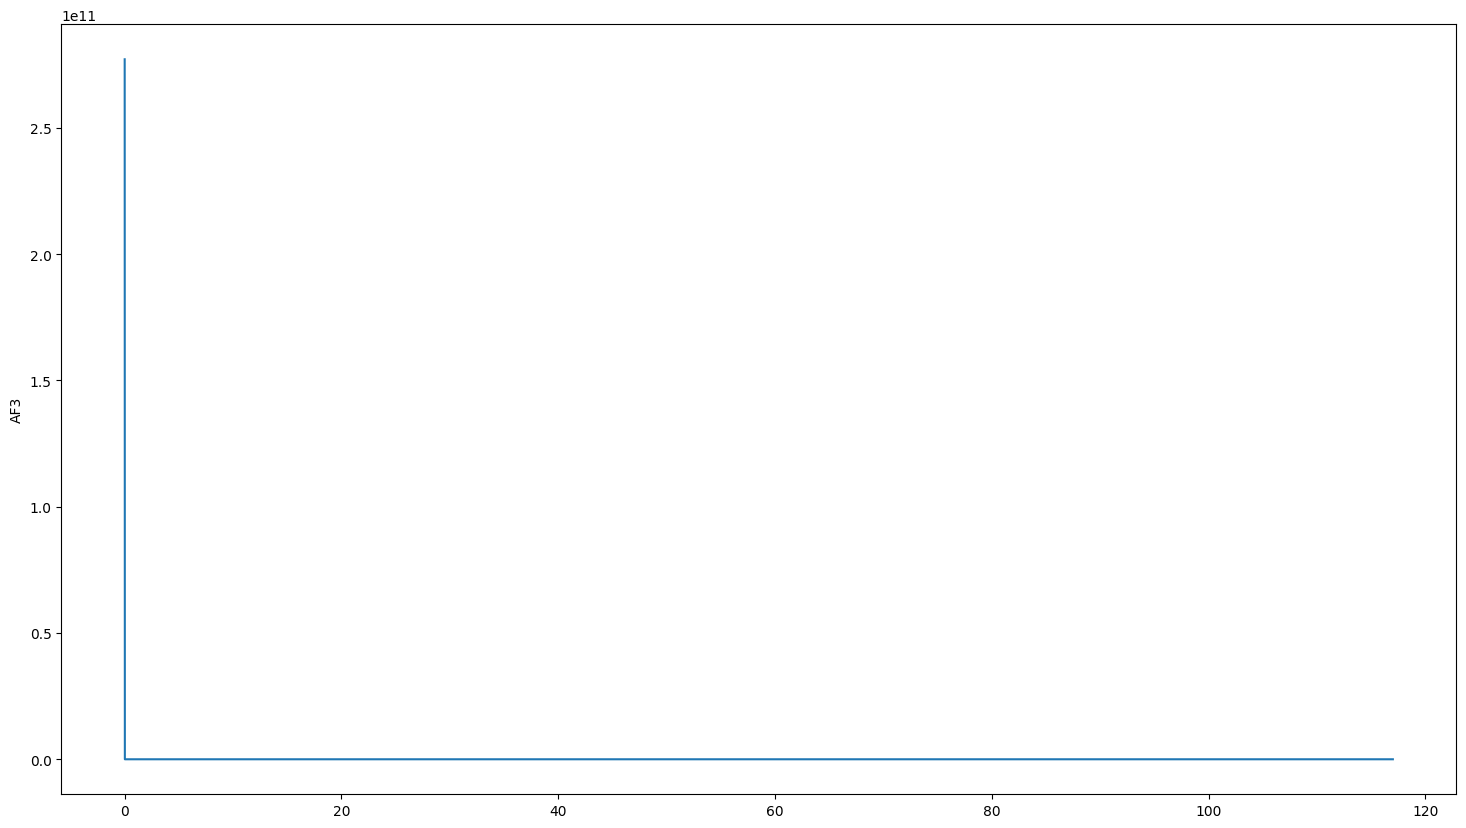

In [18]:
col = "AF3"
plt.ylabel(col)
plt.plot(frequency_range, PSD[col][sample_high_pass:sample_low_pass])

By centering the time-series data at voltage = 0, such that the area under the curve over the recorded data = 0. This sets the PSD = 0, at frequency = 0, so we can clearly see the distribution.

In [19]:
X_Hat = {col:np.fft.fft(X_adj[col] - X_adj[col].mean(), N) for col in X_adj.columns}
PSD = {col:np.real(x_hat * np.conj(x_hat) / N) for col, x_hat in X_Hat.items()}

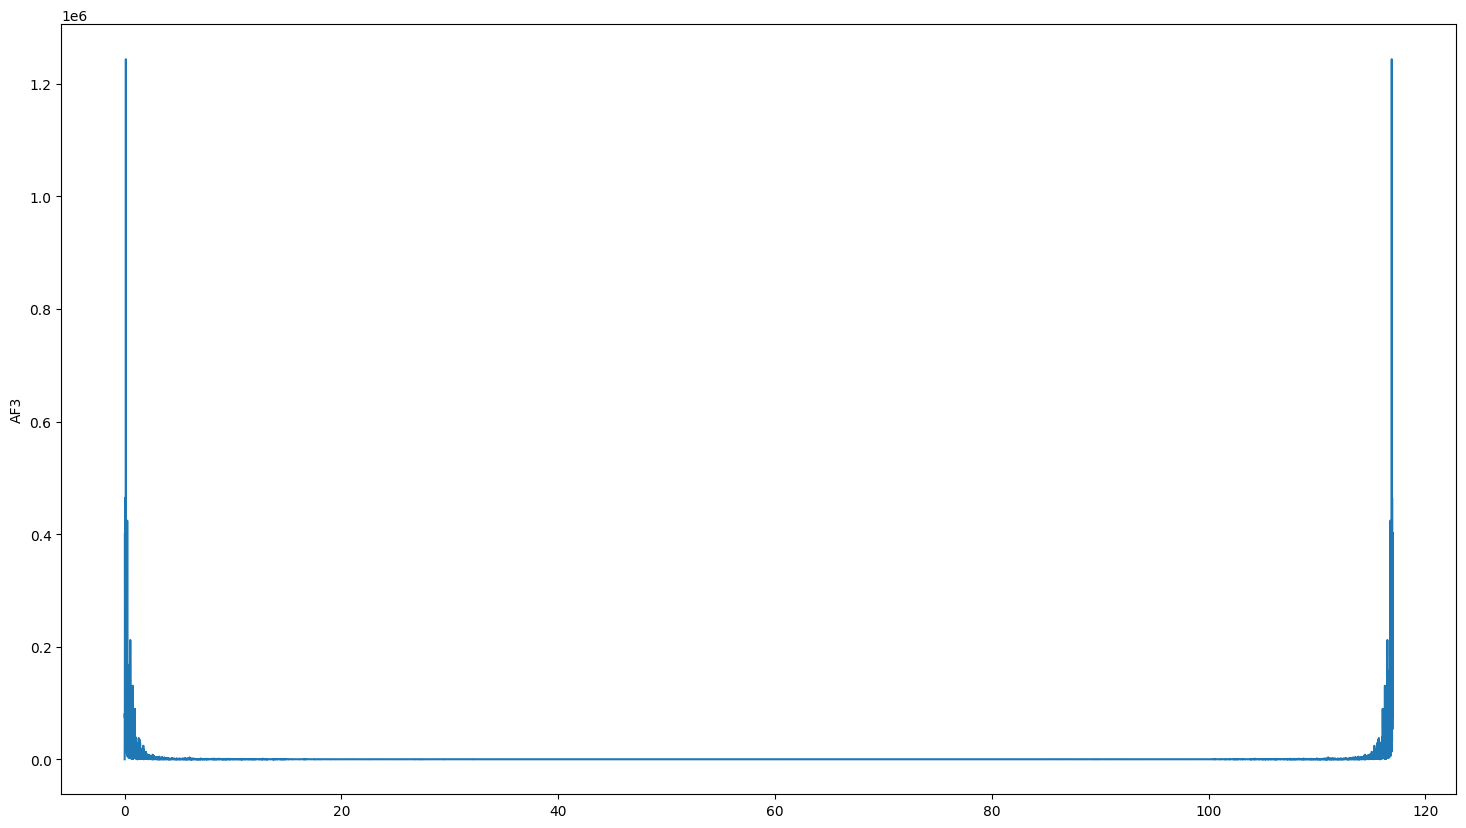

In [20]:
col = "AF3"
plt.ylabel(col)
plt.plot(frequency_range, PSD[col][sample_high_pass:sample_low_pass])

The power specture appears to have an exponential scale. We can plot this in log-PSD scale to get the following plots.
Note: I have also reset the time series data so the power at frequency=0 is no longer 0.

In [21]:
X_Hat = {col:np.fft.fft(X_adj[col], N) for col in X_adj.columns}
PSD = {col:np.real(x_hat * np.conj(x_hat) / N) for col, x_hat in X_Hat.items()}
log_PSD = {col:np.log(np.real(x_hat * np.conj(x_hat) / N)) for col, x_hat in X_Hat.items()}

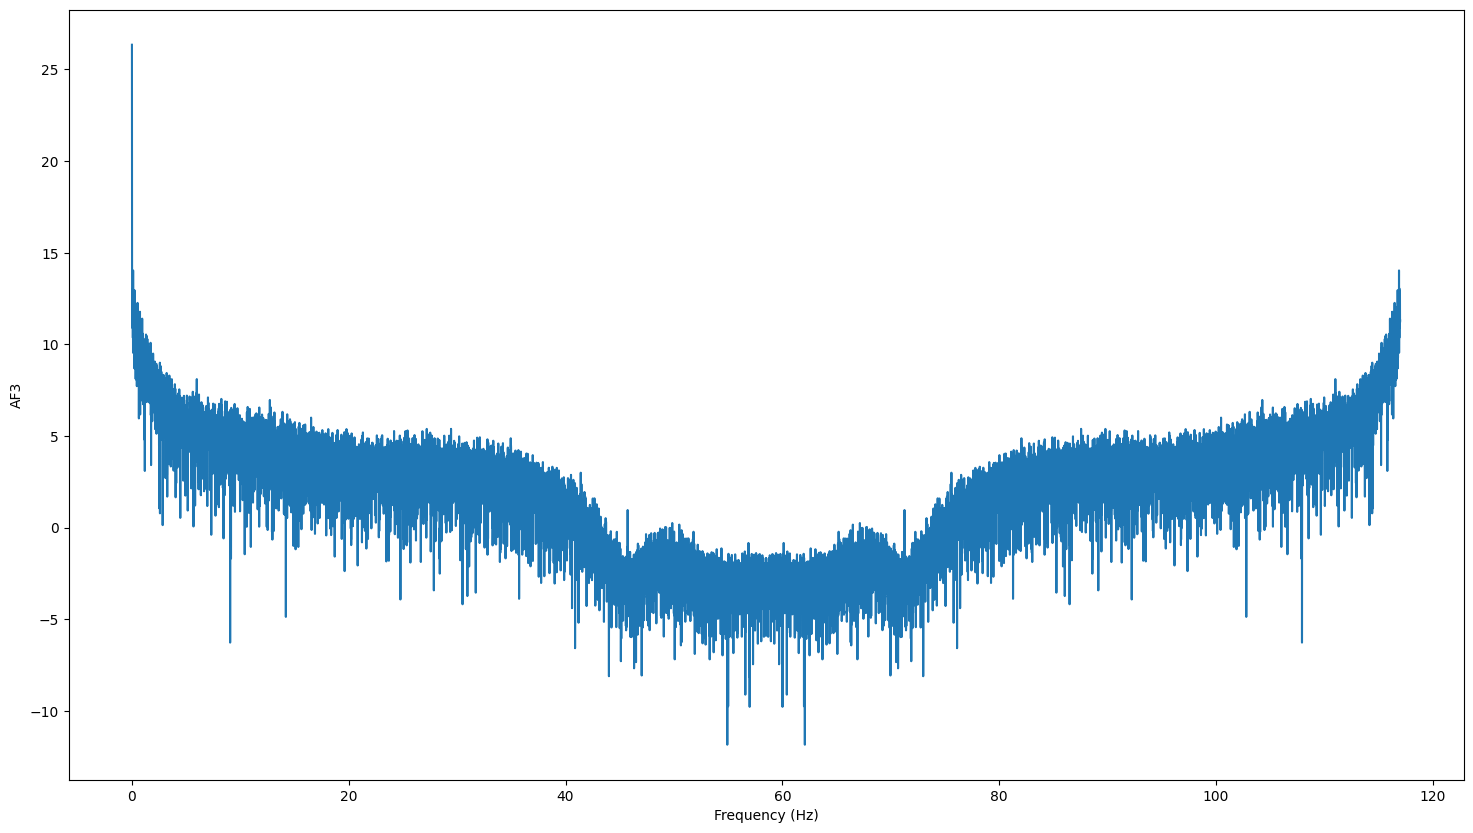

In [22]:
for i, column in enumerate(log_PSD):
    if i != 0: break # Used in testing
    
    fig, ax = plt.subplots()
    
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel(column)
    ax.plot(frequency_range, log_PSD[column][sample_high_pass:sample_low_pass])
    
    plt.show()
    #fig.savefig(f"{column}: log_PSD vs Time_FFT")

This yields a quite an interesting distribution of different frequencies. Almost like a bat shape! Based on this distribution, we can set a power threshold, to filter out those frequencies with a relatively high power to reduce the noise coming from lower power frequencies. But the threshold cannot be too high as that would oversimplify the shape of the plot

# Inverse FFT and Noise Reduction
* Set a power threshold - only frequencies with a higher power will be considered to reduce noise from the original data

In [23]:
power_threshold = 1e4  # Best minimum threshold to reduce noise sufficiently, found by experimentation
allowed_frequencies = {col:psd > power_threshold for col, psd in PSD.items()}
iX_Hat = {col:np.fft.ifft(x_hat * allowed_frequencies[col]) for col, x_hat in X_Hat.items()}

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


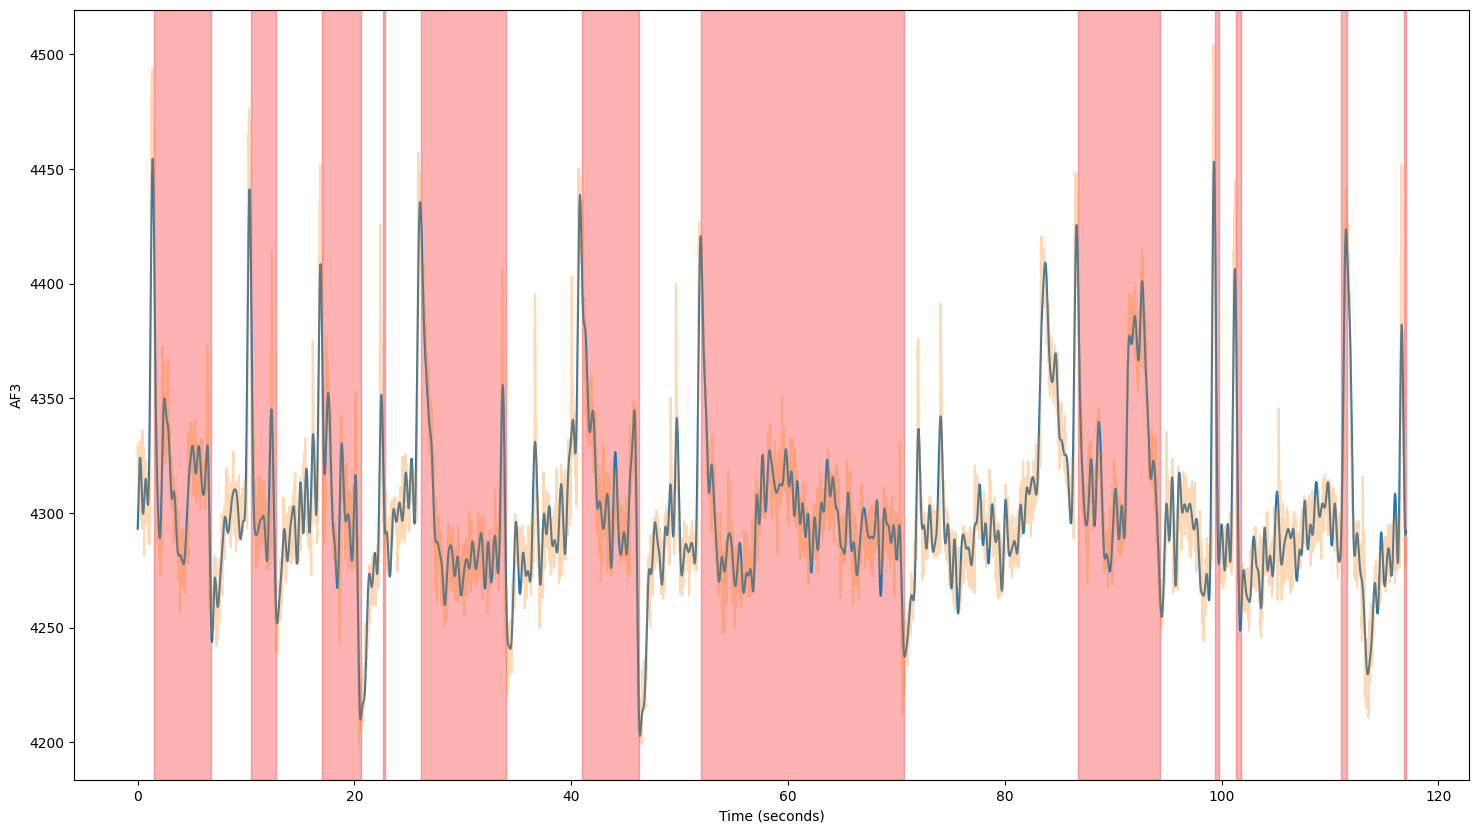

In [24]:
for col, ix_hat in iX_Hat.items():
    if col != "AF3": break   # Used for testing
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel(col)
    # Denoised plot of original data
    ax.plot(scale(np.arange(N)), ix_hat)
    
    # Original plot for comparison
    ax.plot(scale(np.arange(N)), X_adj[col], alpha=0.3)
    
    for i, j in y_ranges:
        ax.axvspan(scale(i), scale(j), color='red', alpha=0.3)
    
    plt.show()
    #fig.savefig(f"{column}: Voltage vs Time_denoised data")

From the above plots, we can make a few key observations:
1. AF3 and AF4 appear to have a clear pattern when the eye state changes from open to closed and, to some extent, closed to open as well
    * This observation can be easily explained isnce the AF3 and AF4 electrodes are located just above the left and right eye respectively, and would be picking up on muscular electoical activity when the eye is closed or opened
2. None of the plots seem to have any obvious patterns when the eyes stay open or stay closed for extended periods of time
3. There is still a clear outlier to observation 1, at about 85s, where we see a spike similar to when the eye is about to close, but no change of state occurs.

From the first point, it is clear we need to employ a sequential model to predict the eye state, such as a **Hidden Markov Model, RNN or LSTM**.

But first, we need to downsample.

## Downsample
* factor: factor by which time scale is down sampled. If this is not done, we would need (approximately) a 20th order Markov model

In [25]:
def downsample(X, factor=20):
    """
    Downsample any input array
    @param X: Input array
    @param factor: downsampling factor
    @return: An array downsampled such that len(X) = factor * len(output)
    """
    return X[::factor]

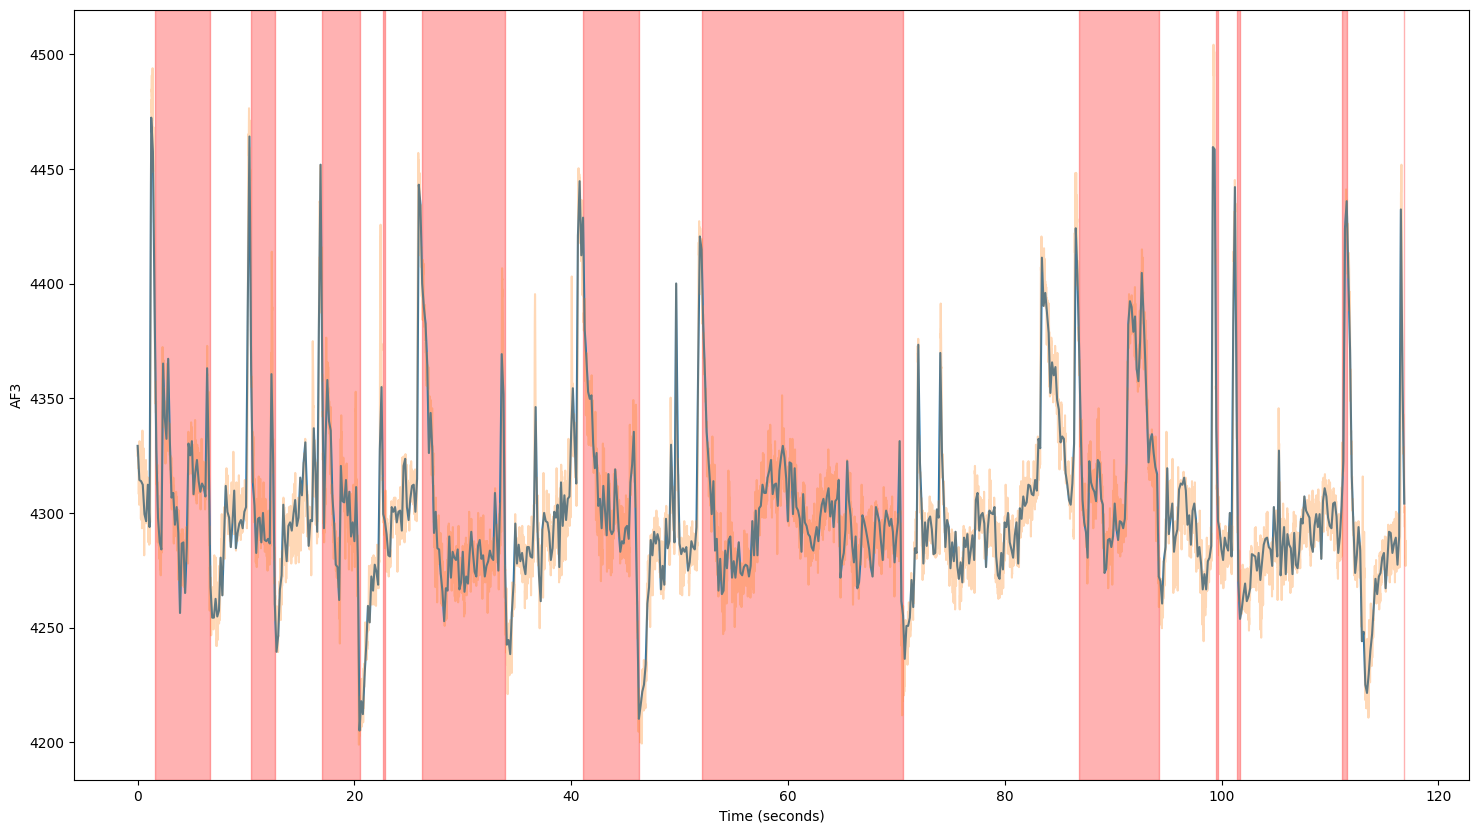

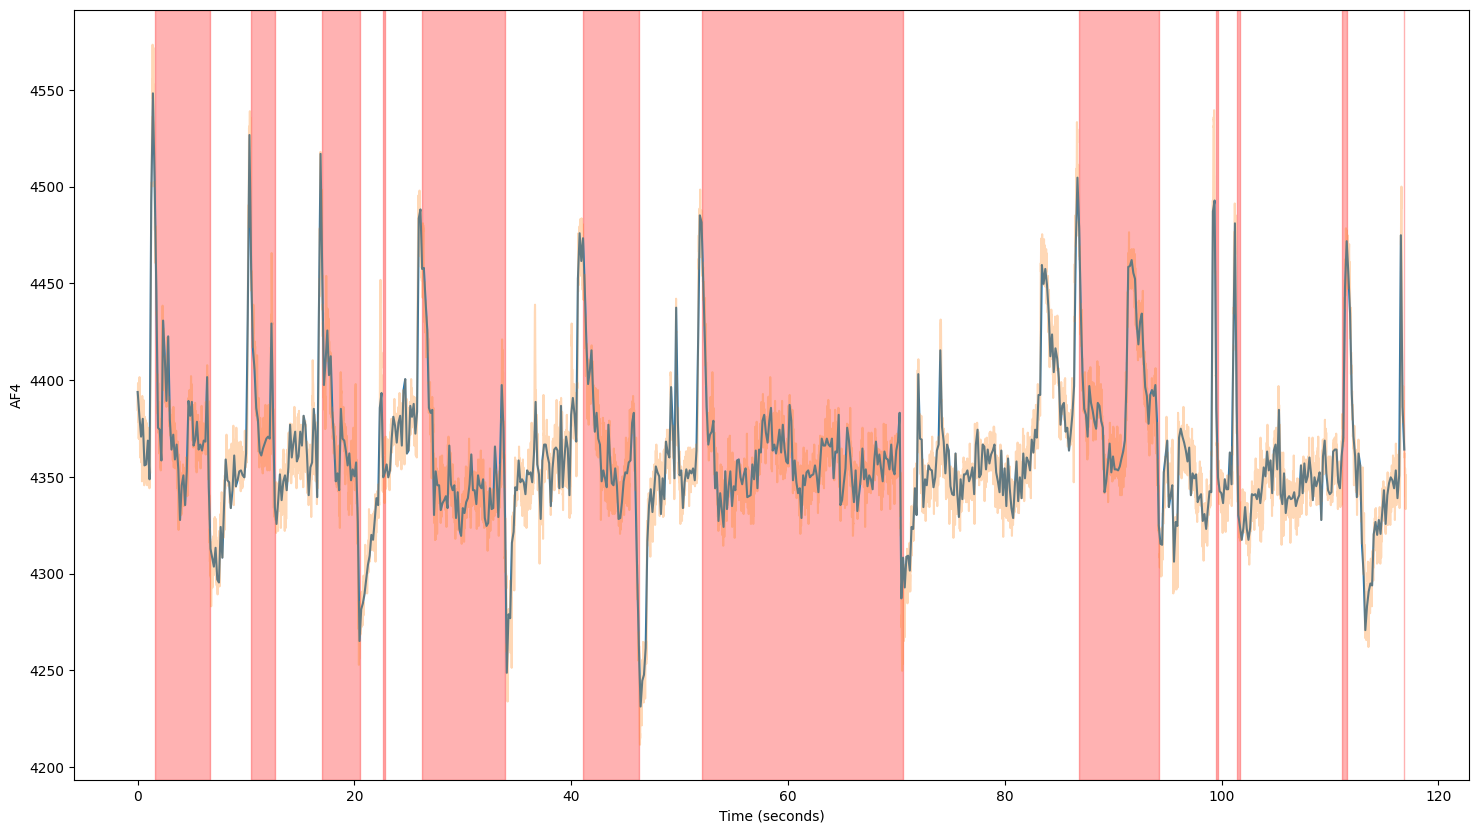

In [26]:
pred_columns = ["AF3", "AF4"]
Y_hmm = {col:downsample(X_adj[col]).values.astype('float32') for col in pred_columns}
X_hmm = downsample(y.values.flatten()).astype(int)
x_hmm_ranges = get_state_ranges(pd.Series(X_hmm))
factor = N / len(Y_hmm["AF3"])

for col, y_hmm in Y_hmm.items():
    #if col != "AF3": break   # Used for testing
    fig, ax = plt.subplots()
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel(col)
    # Denoised plot of original data
    ax.plot(scale(np.arange(len(y_hmm)) * factor), y_hmm)
    
    # Original plot for comparison
    ax.plot(scale(np.arange(N)), X_adj[col], alpha=0.3)
    
    for i, j in x_hmm_ranges:
        ax.axvspan(scale(i * factor), scale(j * factor), color='red', alpha=0.3)
    
    plt.show()

# Hidden Markov Model (HMM) Implementation
* order: A hyperparameter of the HMM representing the number of previous states we need to consider to make a prediction about the current state
* X_hmm: Hidden states. Here it is the eye state at each time step
* Y_hmm: Emissions. Here we have 2 possible emissions, the rocordings for AF3 and AF4
* disc_Y_hmm: Discretised emissions used instead of Y_hmm, since Y_hmm can take a continuous domain of values. Discretisation is done by defining buckets of values the recordings can have. The no. of buckets is also a hyperparameter to be optimised.

In [27]:
def discretise(A, num_buckets = 25):
    """
    To turn the continuous range of voltages into dsicrete buckets
    @param A: Array to discretise
    @param num_buckets: Number of buckets in which to split the complete range of voltages into
    @return: Array of same size as A, but containing the bucket numbers which each voltage belongs in
    """
    
    buckets = np.quantile(A, np.arange(num_buckets+1) / num_buckets)
    return np.digitize(A, buckets, right=True)

In [28]:
disc_Y_hmm = {col:discretise(Y_hmm[col]) for col in Y_hmm.keys()}

# For data visualisation
"""
for col in disc_Y_hmm.keys():
    fig, ax = plt.subplots()
    ax.plot(scale(np.arange(len(disc_Y_hmm[col])) * factor), disc_Y_hmm[col])
    for i, j in x_hmm_ranges:
        ax.axvspan(scale(i * factor), scale(j * factor), color='red', alpha=0.3)
"""

"\nfor col in disc_Y_hmm.keys():\n    fig, ax = plt.subplots()\n    ax.plot(scale(np.arange(len(disc_Y_hmm[col])) * factor), disc_Y_hmm[col])\n    for i, j in x_hmm_ranges:\n        ax.axvspan(scale(i * factor), scale(j * factor), color='red', alpha=0.3)\n"

In [29]:
def HMM(X_hmm, Y_hmm, order=2):
    """
    Compute the transition and emission probabilities of the relevant HMM
    @param X_hmm: hidden states. An array of the eye states at each time step
    @param Y_hmm: emissions. Dictionary with key being the electrode locaiton and value being the recording for the specific 
                            electrode
    @param order: Order of HMM. Each state depends on the previous {order} states and each emission depends on the previous 
                {order} states and emissions
    @return: Tuple of transition and emission probabilities
    """
    
    unique_states = set(X_hmm)
    unique_emissions_split = {col:set(Y_hmm[col]) for col in Y_hmm.keys()}
    unique_emissions = set.union(*[set(Y_hmm[col]) for col in Y_hmm.keys()])
    n = len(X_hmm)
    
    """
    Initialise transition and emission probabilities
    Transition probabilities is a dictionary, with keys being tuples with sequences of hidden states of size order+1
    Emission probabilities is a dictionary. Keys have the structure ((order+1), (order))
    The first tuple in the above pair is a possible sequence of hidden states of size order+1
    The second tuple is a possible sequence of emissions of size order
    """
    transition_probs = {p:0 for p in itertools.product(unique_states, repeat=order+1)}
    emission_probs_split = {col:{p:0 for p in itertools.product(list(itertools.product(unique_states, repeat=order+1)), 
                                                          list(itertools.product(unique_emissions_split[col], repeat=order+1)))} 
                      for col in unique_emissions_split.keys()}
    emission_probs = {p:0 for p in itertools.product(list(itertools.product(unique_states, repeat=order+1)), 
                                                         list(itertools.product(unique_emissions, repeat=order+1)))} 
    
    # Count of total occurrences of each type of state transition of size order
    # Cound of total occurrences of each type of state transition of size order + 1 with emissinons of size order
    transition_totals = {p:0 for p in itertools.product(unique_states, repeat=order)}
    emission_split_totals = {col:{p:0 for p in itertools.product(list(itertools.product(unique_states, repeat=order+1)), 
                                                          list(itertools.product(unique_emissions_split[col], repeat=order)))} 
                              for col in unique_emissions_split.keys()}
    emission_totals = {p:0 for p in itertools.product(list(itertools.product(unique_states, repeat=order+1)), 
                                                         list(itertools.product(unique_emissions, repeat=order)))} 
    
    for i in range(n - order):
        
        # Storing the sequence of hidden states of size order + 1
        # Storing sequence of emissions of size order
        hid_seq = tuple(X_hmm[i:i+order+1])
        em_seq = {col: tuple(Y_hmm[col][i:i+order+1]) for col in Y_hmm.keys()}
        
        # Counting no. of occurrences of transitions and emissions
        transition_probs[hid_seq] += 1
        transition_totals[hid_seq[:-1]] += 1
        
        for col, seq in em_seq.items():
            emission_probs_split[col][(hid_seq, seq)] += 1
            emission_probs[(hid_seq, seq)] += 1
            
            emission_split_totals[col][(hid_seq, seq[:-1])] += 1
            emission_totals[(hid_seq, seq[:-1])] += 1
    
    # Validation of counts
    #print({p:v for p, v in transition_probs.items() if v != 0})
    #print({col:{p:v for p, v in em.items() if v >3} for col, em in emission_probs_split.items()})
    #print({p:v for p, v in emission_probs.items() if v >3})
    
    # Smoothing  counts of specific sequence occurrences
    smoothing_bias = 0.1
    num_splits = len(unique_emissions_split)
    transition_probs = {hid_seq: c + smoothing_bias for hid_seq, c in transition_probs.items()}
    emission_probs_split = {col: {seq: c + smoothing_bias for seq, c in em_seq.items()} 
                            for col, em_seq in emission_probs_split.items()}
    emission_probs = {seq: c + num_splits * smoothing_bias for seq, c in emission_probs.items()}
    
    # Smoothing counts of totals
    num_unique_states, num_unique_emissions = len(unique_states), len(unique_emissions)
    num_unique_emissions_split = {col: len(unique_em) for col, unique_em in unique_emissions_split.items()}
    
    transition_totals = {hid_seq: c + smoothing_bias * num_unique_states for hid_seq, c in transition_totals.items()}
    emission_split_totals = {col: {seq: c + smoothing_bias * num_unique_emissions_split[col] for seq, c in em_seq.items()} 
                            for col, em_seq in emission_split_totals.items()}
    emission_totals = {seq: c + num_splits * smoothing_bias * num_unique_emissions for seq, c in emission_totals.items()}
    
    # Computing probabilities from counts, then finding log probabilities for precision
    for hid_seq, c in transition_probs.items():
        transition_probs[hid_seq] = np.log(c / transition_totals[hid_seq[:-1]])
        
    for col, em in emission_probs_split.items():
        for (hid_seq, em_seq), c in em.items():
            emission_probs_split[col][(hid_seq, em_seq)] = np.log(c / emission_split_totals[col][(hid_seq, em_seq[:-1])])
            
    for (hid_seq, em_seq), c in emission_probs.items():
        emission_probs[(hid_seq, em_seq)] = np.log(c / emission_totals[(hid_seq, em_seq[:-1])])
    
    #transition_probs = {col: np.log(0.5) for col in transition_probs.keys()}
    
    return transition_probs, emission_probs_split, emission_probs

## Return values of the HMM
* A: Transition probabilities
* B: Emission probabiltiies, split by the location of EEG recording the probabilities were computed on. So it is a dictionary of the form {"AF3": emission probabilities of AF3 observations, "AF4": emission probabilities of AF4 observations}
* C: Emission probabilities, combined from each location of the EEG recordings

In [30]:
A, B, C = HMM(X_hmm, disc_Y_hmm)

# Forward & Viterbi Algorithm
The Implementation of the Forward and Viterbi algorithms are centered around delta and psi:
* delta: An array with the same size as no. of observed emissions. Each element of delta is a dictionary with keys as a set of all possible triples of hidden states (eg (0, 1, 0), (1, 0, 0), etc.) and values being the max probabilities P(X | O, HMM), where X is the sequence of hidden states so far, O is the sequence of emissions so far and HMM represents a specific instance of a trained Hidden Markov Model
    * The last element of delta contains the max probabilities P(X | O, HMM) over all sequences of hidden states, given the complete set of observed observed emissions and given a trained HMM. This is the value we are after.
* psi: An array with the same size as delta and same keys within each element of the array as delta. The values are meant to keep track of the most likely previous hidden state triple (eg (0, 1, 0), (1, 0, 0), etc.) to lead to the current hidden triple
* delta_split and psi_split are similar to delta and psi, but they perform a separate computation for each feature, AF3 and AF4, while delta and psi aggregate the computation taking into account both features
* Usage of the split vs normal variables is meant to provide an understanding of which of the features, or whether aggregated feature, is more indicative of the eye state

In [31]:
def HMM_predict(A, B, C, emissions):
    """
    Given a trained HMM and the sequence of emissions, predicts the probability of the sequence of emissions and most likely
    sequence of hidden states which caused this sequence of emissions
    @param A: transition probabilities, returnd by HMM
    @param B: emission probabilities split by each electorde location, returned by HMM
    @param C: emission probabilities, aggregated over all relevant electrode locations, returned by HMM
    @param emissions: A new seuqnece of emissions of each relevanrt electrode
    @return: The most likely sequence of hidden states which led to the observed sequence of emissions along with the
             probability of observing this sequence of emissions
    """
    
    samples = len(list(emissions.values())[0])
    unique_states = set.union(*[set(k) for k in A.keys()])
    order = len(list(A.keys())[0]) - 1
    unique_emissions = set.union(*[set(em) for (hid, em) in C.keys()])
    
    # Delta stores the max log probabilities of all sequences of hidden states of length i+1, ending with the current state s
    delta_split = {col:[{s: float('-inf') for s in A.keys()} for i in range(samples)] 
                   for col, seq in emissions.items()}
    delta = [{s: float('-inf') for s in A.keys()} for i in range(samples)]
    
    # Psi stores the most likely previous hidden state which lead to the current potential hidden state
    psi_split = {col:[{s: -1 for s in A.keys()} for i in range(samples)] 
                   for col, seq in emissions.items()}
    psi = [{s: -1 for s in A.keys()} for i in range(samples)]
    
    # Initalisation of start stage
    for i in range(order):
        for col in delta_split.keys():
            # Initialisation of first <order> levels of delta values
            delta_split[col][i] = {s: 0 for s in A.keys()}
        
        delta[i] = {s: 0 for s in A.keys()}
    
    # Computing remaining delta and psi values
    for t in range(order, samples):
        
        for prev_hid_seq, cur_hid_seq in filter(lambda x: x[0][1:] == x[1][:-1], itertools.product(A.keys(), repeat=2)):
            
            # Partially compute delta
            prob = delta[t-1][prev_hid_seq] + A[cur_hid_seq]
            
            for col in delta_split.keys():
                
                # Computation of delta_split
                prob_split = delta_split[col][t-1][prev_hid_seq] + A[cur_hid_seq] + B[col][(cur_hid_seq, tuple(emissions[col][t-order:t+1]))]
                if prob_split > delta_split[col][t][cur_hid_seq]:
                    delta_split[col][t][cur_hid_seq] = prob_split
                    psi_split[col][t][cur_hid_seq] = prev_hid_seq
                
                # Completing commputation of delta
                prob += C[(cur_hid_seq, tuple(emissions[col][t-order:t+1]))]
            
            if prob > delta[t][cur_hid_seq]:
                    delta[t][cur_hid_seq] = prob
                    psi[t][cur_hid_seq] = prev_hid_seq
            
    
    # Finding the most sequence of hidden states
    pred_hid_seq_split = {col:list(max(delta_split[col][-1], key=delta_split[col][-1].get)) for col in delta_split.keys()}
    pred_hid_seq = list(max(delta[-1], key=delta[-1].get))
    
    for t in range(samples-1, order, -1):
        for col in pred_hid_seq_split.keys():
            pred_hid_seq_split[col] = [psi_split[col][t][tuple(pred_hid_seq_split[col][:order+1])][0]] + pred_hid_seq_split[col]
        pred_hid_seq = [psi[t][tuple(pred_hid_seq[:order+1])][0]] + pred_hid_seq
    
    pred_hid_seq_split["AGGREGATE"] = pred_hid_seq
    
    return pred_hid_seq_split
        

## Training and Testing HMM
* hmm_train_test() - Define a way to split the eye states and EEG recordings data into training and testing. Done using a simple train_test_split, defining a boundary index as the boundary between training and testing data and splitting the data into the 2 sets accordingly.

In [32]:
def hmm_train_test(X, Y, train_test_ratio = 0.8):
    """
    Compute a train-test split on the specific data structures used for HMM
    @param X: Array of hidden state samples (eye states)
    @param Y: dictionary of emissions (relevant EEG recordings used to predict hidden states)
    @param train_test_ratio: proportion of samples used as training data, taken from the start till the train-test boundary
                            1 - train_test_ratio is the proportion used for testing, taken from the train-test boundary till the end
    @return: A tuple of 4 values of the form (states for training, emissions for training, states for testing, emissions for testing)
    """
    
    num_train = int(len(X) * train_test_ratio)
    X_train, X_test = X[:num_train], X[num_train:]
    Y_train, Y_test = {col: val[:num_train] for col, val in Y.items()}, {col: val[num_train:] for col, val in Y.items()}
    return X_train, Y_train, X_test, Y_test

In [33]:
X_hmm_train, disc_Y_hmm_train, X_hmm_test, disc_Y_hmm_test = hmm_train_test(X_hmm, disc_Y_hmm, train_test_ratio = 0.6)

# Training HMM
A, B, C = HMM(X_hmm_train, disc_Y_hmm_train)

# Making predictions using HMM
predictions = HMM_predict(A, B, C, disc_Y_hmm_test)
#print(predictions)

## Visualise HMM predictions
* The predictions are made by 3 types of HMMs
    * Trained on "AF3" electrode only
    * Trained on "AF4" electrode only
    * Trained on both "AF3" and "AF4" electordes
* Visualisation for the first 2 sets of predictions is by plotting the EEG recordings for the respective electrode and filling in bands of colours for when prediction is eye state = 1 and actual eye state = 1
* Visualisation of the last set of predictions is by plotting both electrodes' EEG recordings and filling in the bands for when the predicted eye state = 1 and actual eye state = 1
* The band colours are defined as such:
    * red: when actual eye state = 1
    * yellow: when predicted eye state = 1
    * orange: overlap between red and yellow bands, when actual == predicted
    * black: line drawn to define boundary between train and test data

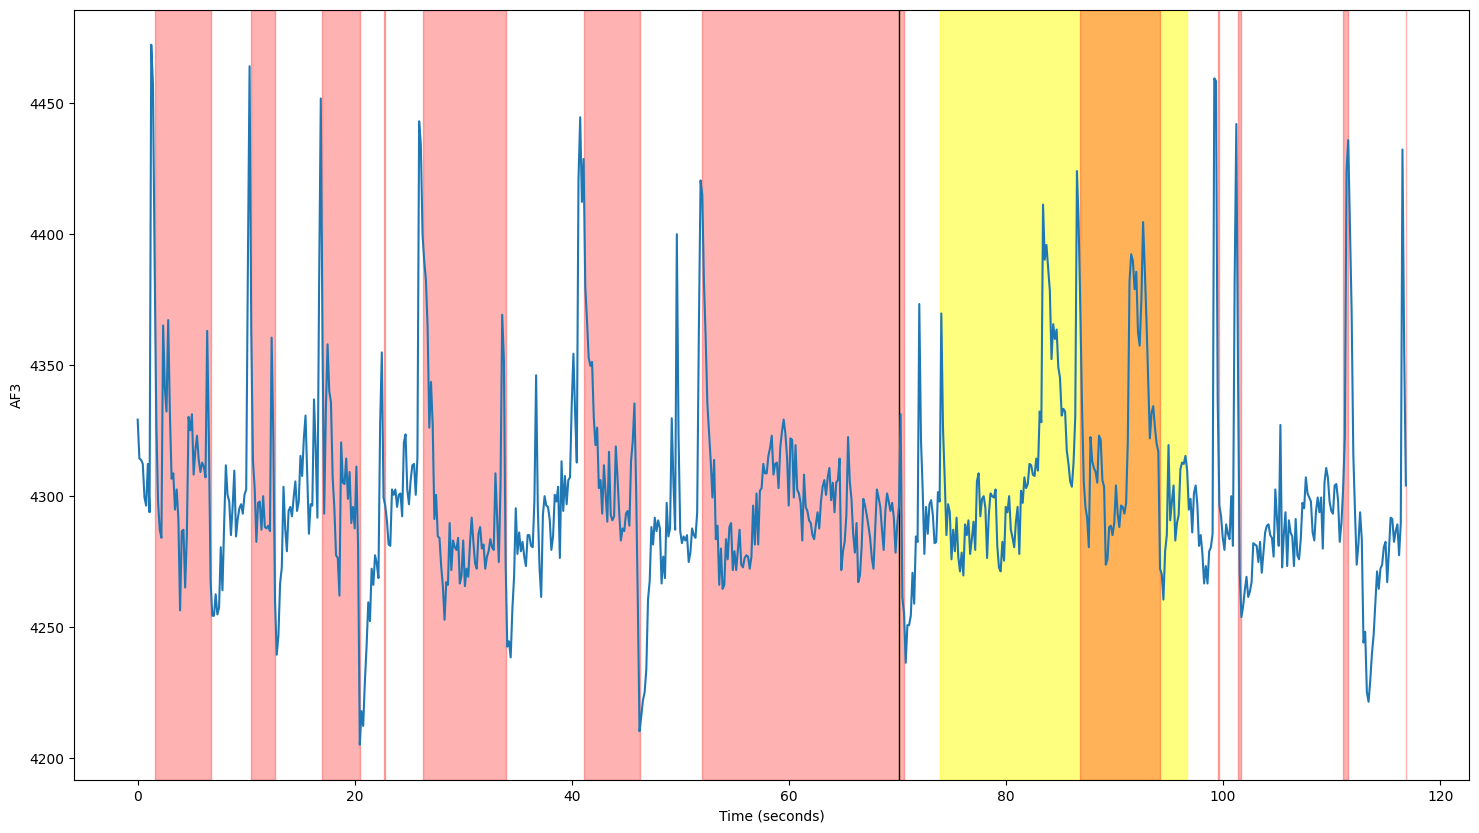

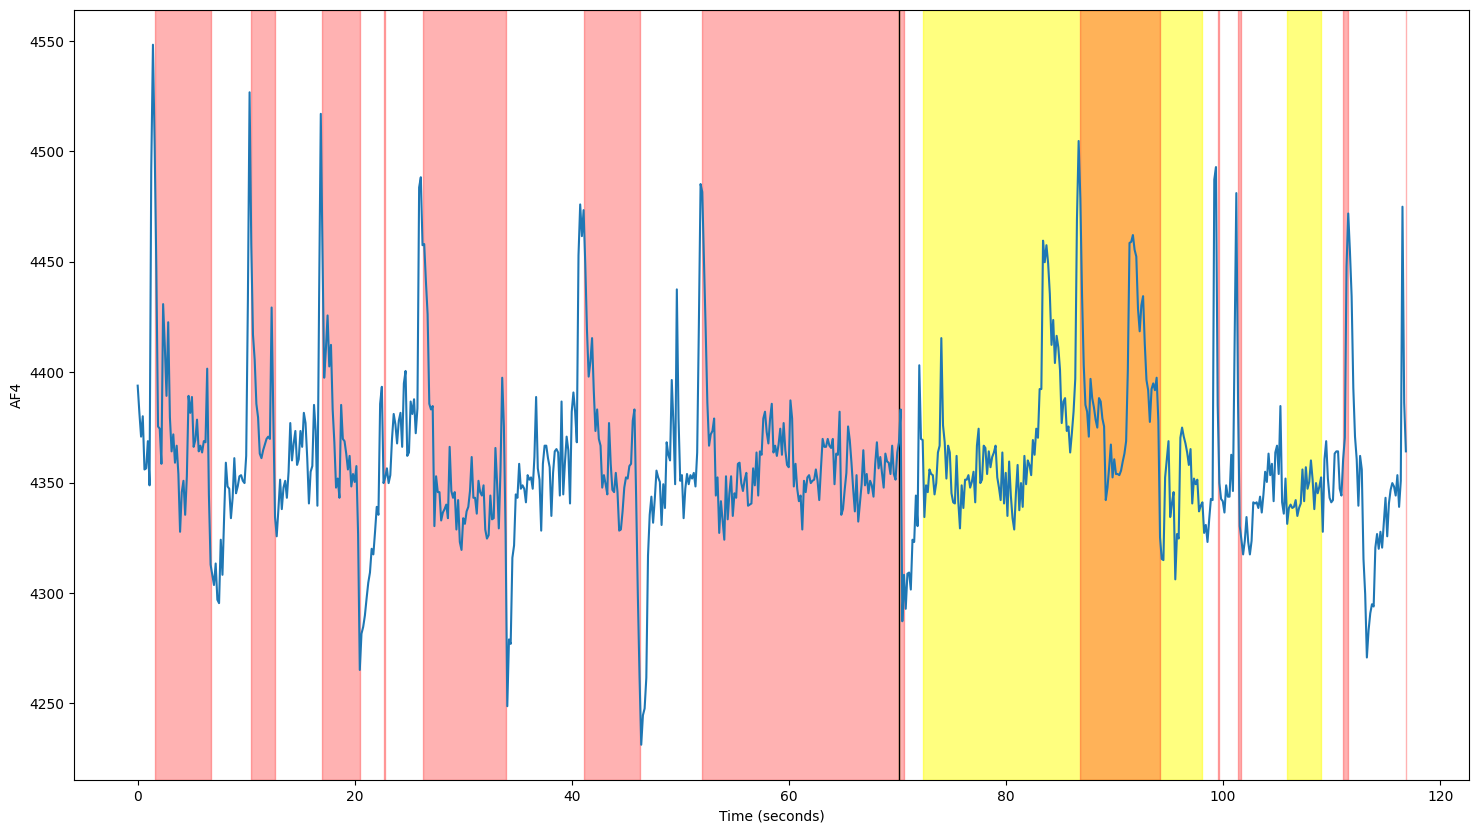

In [34]:
# Visualising model accuracy when training using a single electrode
for col, pred in predictions.items():
    
    # Visualising aggregate performed separately
    if col == "AGGREGATE": continue
    
    # Upsampling factor
    factor = N / len(Y_hmm[col])
    
    # Finding ranges where prediction of the model is that eye state = 1
    pred_ranges = get_state_ranges(pred)
    train_test_boundary = len(X_hmm_train)
    band_ranges = [(i + train_test_boundary, j + train_test_boundary) for i, j in pred_ranges]
    
    # Plot EEG recording
    fig, ax = plt.subplots()
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel(col)
    #ax.set_xlim([scale(train_test_boundary * factor - 1), time_scale])
    ax.plot(scale(np.arange(len(Y_hmm[col])) * factor), Y_hmm[col])
    
    # Fill in colours where model predicted eye sttate = 1 as yellow
    for i, j in band_ranges:
        ax.axvspan(scale(i * factor), scale(j * factor), color='yellow', alpha=0.5)
    
    # Fill in colour where actual eye state = 1 as red
    for i, j in x_hmm_ranges:
        ax.axvspan(scale(i * factor), scale(j * factor), color='red', alpha=0.3)
    
    # Draw a line defining boundary between train data and test data in black colour
    ax.axvspan(scale(train_test_boundary * factor - 1), scale(train_test_boundary * factor), color="black")


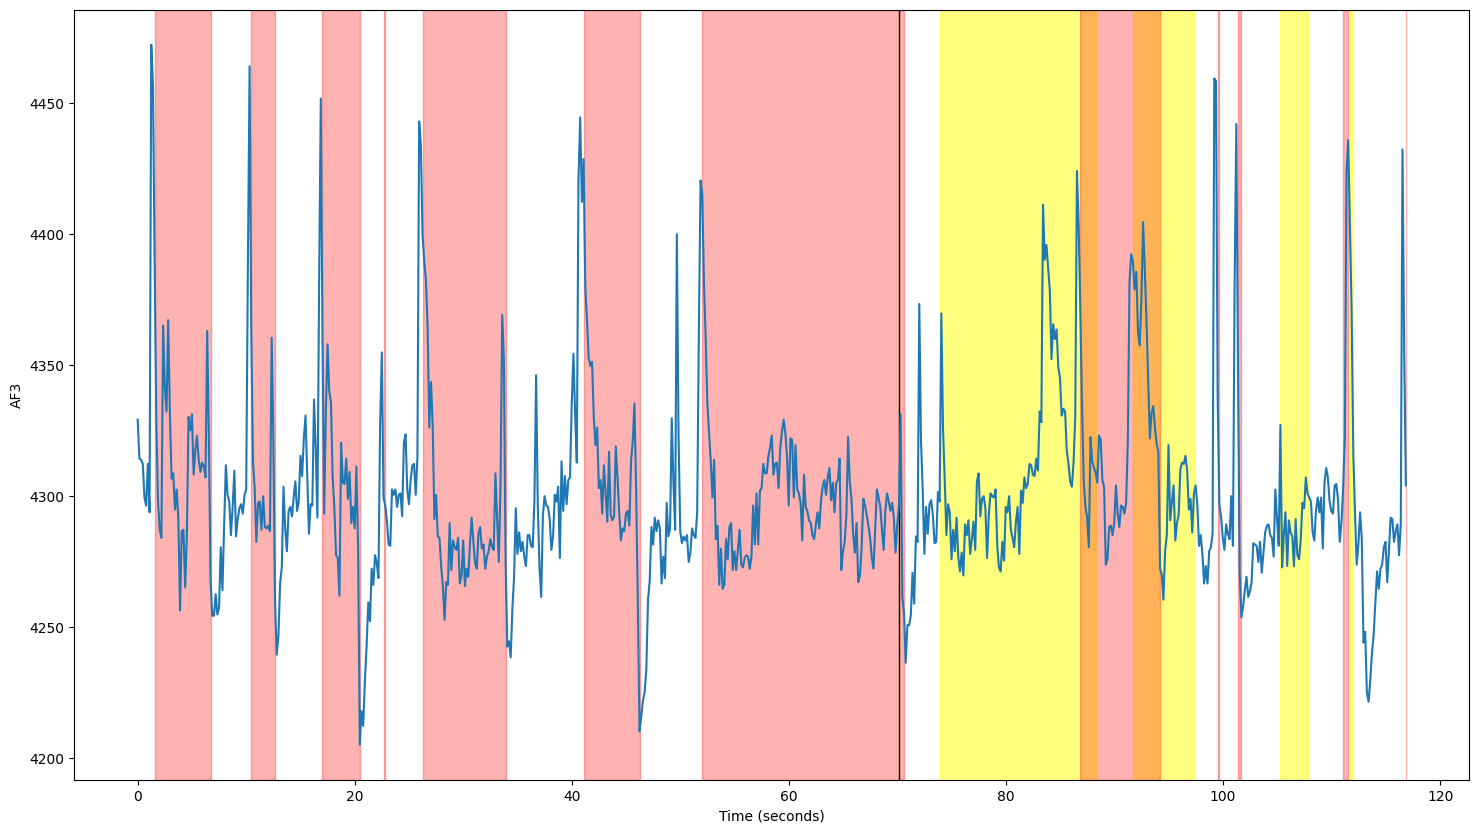

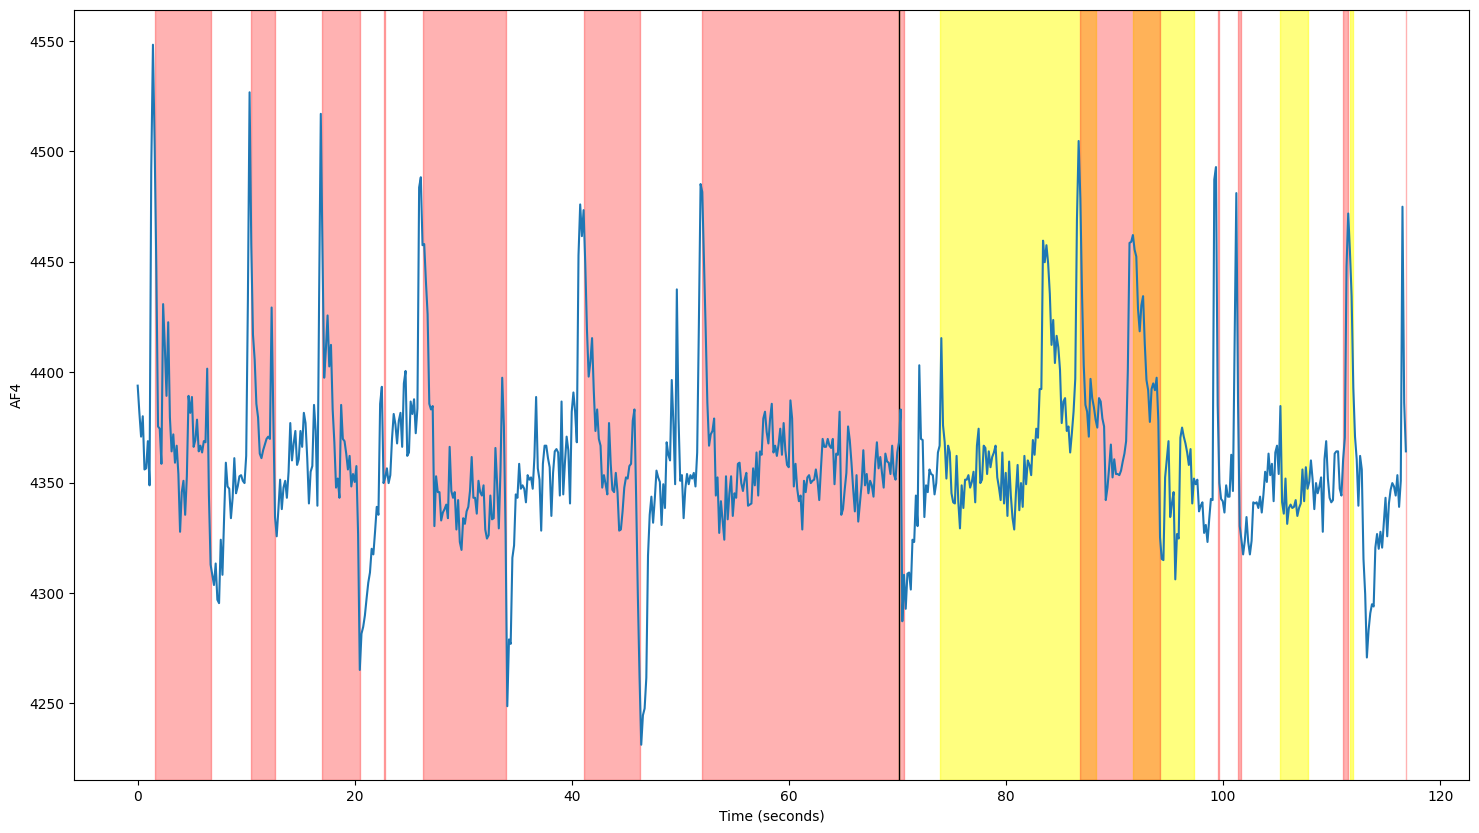

In [35]:
# Visualise model accuracy, for model trained on all relevant electrodes combined
pred = predictions['AGGREGATE']
for col, y_hmm in Y_hmm.items():

    # Upsampling factor
    factor = N / len(y_hmm)
    
    # Finding ranges where prediction of the model is that eye state = 1
    pred_ranges = get_state_ranges(pred)
    train_test_boundary = len(X_hmm_train)
    band_ranges = [(i + train_test_boundary, j + train_test_boundary) for i, j in pred_ranges]
    
    # Plot EEG recording
    fig, ax = plt.subplots()
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel(col)
    #ax.set_xlim([scale(train_test_boundary * factor - 1), time_scale])
    ax.plot(scale(np.arange(len(y_hmm)) * factor), y_hmm)
    
    # Fill in colours where model predicted eye sttate = 1 as yellow
    for i, j in band_ranges:
        ax.axvspan(scale(i * factor), scale(j * factor), color='yellow', alpha=0.5)
    
    # Fill in colour where actual eye state = 1 as red
    for i, j in x_hmm_ranges:
        ax.axvspan(scale(i * factor), scale(j * factor), color='red', alpha=0.3)
    
    # Draw a line defining boundary between train data and test data in black colour
    ax.axvspan(scale(train_test_boundary * factor - 1), scale(train_test_boundary * factor), color="black")
